# Decision Trees & Boundaries

Data from: https://www.kaggle.com/datasets/itsmesunil/bank-loan-modelling?select=Bank_Personal_Loan_Modelling.xlsx

In [1]:
!pip install mlxtend --upgrade --no-deps
!pip install dtreeviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 15.8 MB/s eta 0:00:00
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.5/91.5 kB 3.5 MB/s eta 0:00:00


## Setup

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions

In [2]:
df = pd.read_excel("https://raw.githubusercontent.com/pierpaolo28/Anaconda-Machine-Learning-Visualization-Course/main/Data/Bank_Personal_Loan_Modelling.xlsx","Data")
df.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [3]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_values = pd.DataFrame({'percent_missing': percent_missing})
missing_values.sort_values(by ='percent_missing' , ascending=False)

,percent_missing
ID,0.0
Age,0.0
Experience,0.0
Income,0.0
ZIP Code,0.0
Family,0.0
CCAvg,0.0
Education,0.0
Mortgage,0.0
Personal Loan,0.0


In [5]:
X = df.drop(['Personal Loan'], axis=1)
Y = df['Personal Loan']

X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size = 0.30, random_state = 101)
sc = StandardScaler()
X_Train = sc.fit_transform(X_Train)
X_Test = sc.transform(X_Test)

In [6]:
clf = DecisionTreeClassifier(max_depth=2, random_state=0)
clf.fit(X_Train, Y_Train)
y_pred = clf.predict(X_Test)
accuracy_score(Y_Test, y_pred)

0.9633333333333334

## dtreeviz : Decision Tree Visualization

Additional info about dtreeviz and its capabilities can be found in [this article](https://www.tensorflow.org/decision_forests/tutorials/dtreeviz_colab).

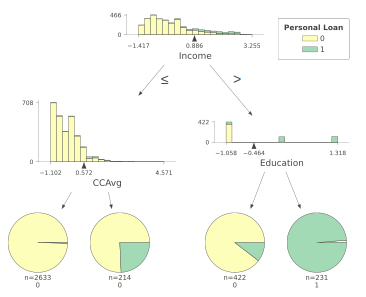

In [7]:
import dtreeviz as dtv
# avoid "Arial font not found warnings"
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

viz = dtv.model(clf,
               X_Train,
               Y_Train,
               target_name='Personal Loan',
               feature_names=list(X.columns),
               class_names=list(Y.unique()))

v = viz.view()    
v.save("dtreeviz.svg") 
viz.view()     

## PCA Reduction

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_X_Train = pca.fit_transform(X_Train)
pca_X_Test = pca.transform(X_Test)
PCA_df = pd.DataFrame(data = np.append(pca_X_Train, pca_X_Test, axis=0),
                      columns = ['PC1', 'PC2'])
PCA_df = pd.concat([PCA_df, df['Personal Loan']], axis = 1)
PCA_df.head()

,PC1,PC2,Personal Loan
0,-1.368655,1.037129,0
1,0.970461,2.876285,0
2,-0.071077,1.361465,0
3,1.131027,-0.180973,0
4,2.162587,-0.460856,0


In [9]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(pca_X_Train, Y_Train)
y_pred = clf.predict(pca_X_Test)
accuracy_score(Y_Test, y_pred)

0.9026666666666666

### Mlxtend

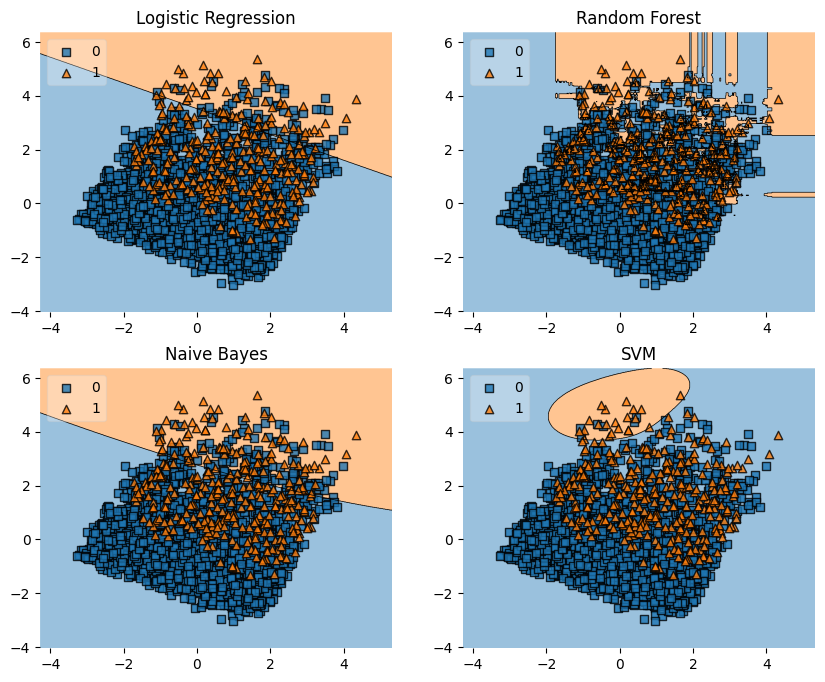

In [10]:
import matplotlib.gridspec as gridspec
from itertools import product

gs = gridspec.GridSpec(2, 2)

fig = plt.figure(figsize=(10,8))

clf1 = LogisticRegression(random_state=1,
                          solver='newton-cg',
                          multi_class='multinomial')
clf2 = RandomForestClassifier(random_state=1, n_estimators=100)
clf3 = GaussianNB()
clf4 = SVC(gamma='auto')

labels = ['Logistic Regression', 'Random Forest', 'Naive Bayes', 'SVM']
for clf, lab, grd in zip([clf1, clf2, clf3, clf4],
                         labels,
                         product([0, 1], repeat=2)):

    clf.fit(pca_X_Train, Y_Train)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(pca_X_Train, Y_Train.values, clf=clf, legend=2)
    plt.title(lab)

plt.savefig("boundaries.png", dpi=300)
plt.show()

### Yellowbrick

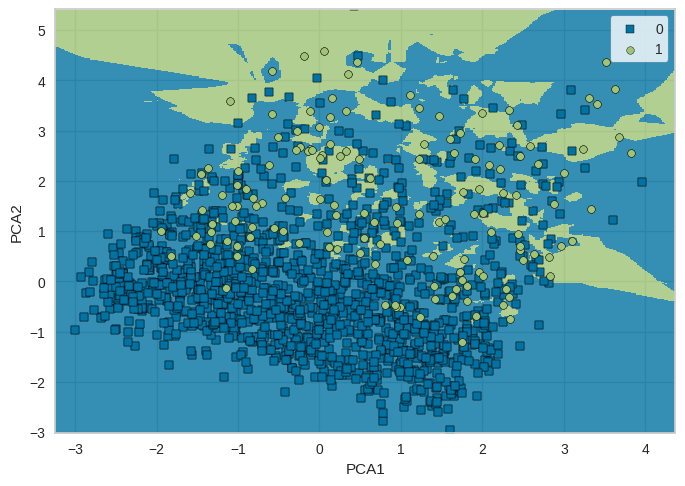

<Axes: xlabel='PCA1', ylabel='PCA2'>

In [11]:
from yellowbrick.contrib.classifier import DecisionViz
from sklearn.neighbors import KNeighborsClassifier

viz = DecisionViz(
    KNeighborsClassifier(3), title="Nearest Neighbors",
    features=['PCA1', 'PCA2'], classes=['0', '1']
)
viz.fit(pca_X_Train, Y_Train.values)
viz.draw(pca_X_Test, Y_Test.values)
viz.show()

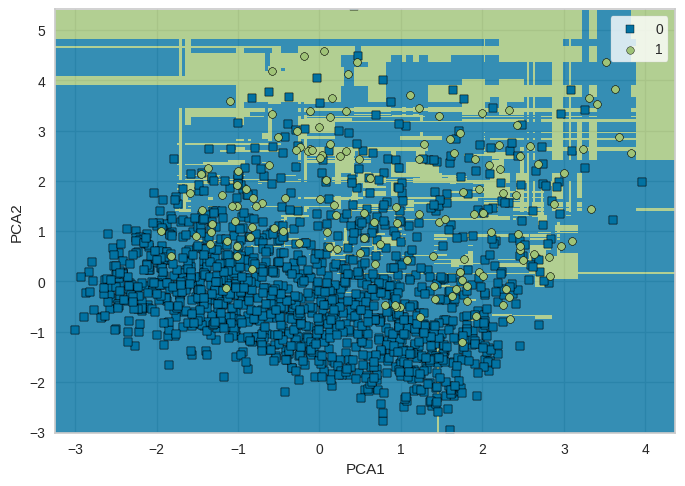

<Axes: xlabel='PCA1', ylabel='PCA2'>

In [12]:
viz = DecisionViz(
    RandomForestClassifier(3), title="Random Forest",
    features=['PCA1', 'PCA2'], classes=['0', '1']
)
viz.fit(pca_X_Train, Y_Train.values)
viz.draw(pca_X_Test, Y_Test.values)
viz.show()

### Sklearn

#### Classical Approach

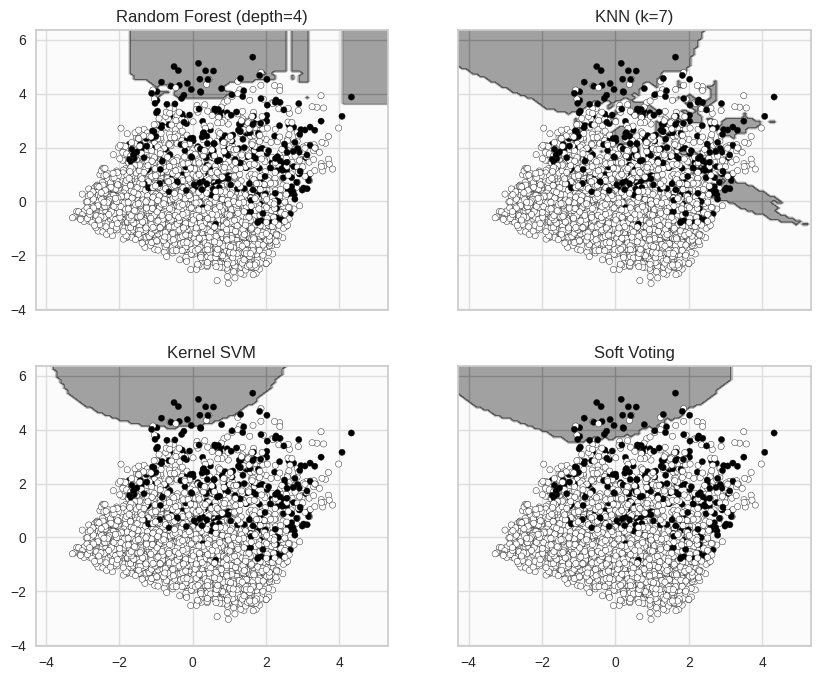

In [13]:
# Following: https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

clf1 = RandomForestClassifier(max_depth=4)
clf2 = KNeighborsClassifier(n_neighbors=7)
clf3 = SVC(gamma=.1, kernel='rbf', probability=True)
eclf = VotingClassifier(estimators=[('rf', clf1), ('knn', clf2),
                                    ('svc', clf3)],
                        voting='soft', weights=[2, 1, 2])

clf1.fit(pca_X_Train, Y_Train)
clf2.fit(pca_X_Train, Y_Train)
clf3.fit(pca_X_Train, Y_Train)
eclf.fit(pca_X_Train, Y_Train)

# Plotting decision regions
x_min, x_max = pca_X_Train[:, 0].min() - 1, pca_X_Train[:, 0].max() + 1
y_min, y_max = pca_X_Train[:, 1].min() - 1, pca_X_Train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        [clf1, clf2, clf3, eclf],
                        ['Random Forest (depth=4)', 'KNN (k=7)',
                         'Kernel SVM', 'Soft Voting']):

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(pca_X_Train[:, 0], pca_X_Train[:, 1], c=Y_Train.values,
                                  s=20, edgecolor='k')
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

#### Using DecisionBoundaryDisplay

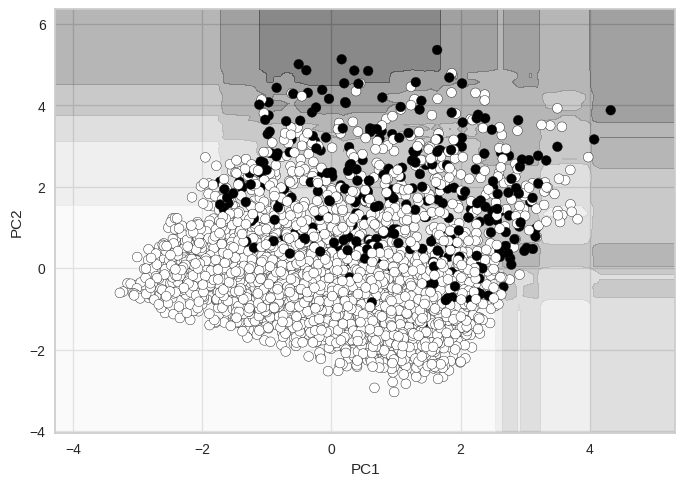

In [14]:
from sklearn.inspection import DecisionBoundaryDisplay

disp = DecisionBoundaryDisplay.from_estimator(
        clf1, pca_X_Train,
        xlabel=PCA_df.columns[0], ylabel=PCA_df.columns[1],
        alpha=0.5)
disp.ax_.scatter(pca_X_Train[:, 0], pca_X_Train[:, 1], c=Y_Train,
                 edgecolor="k")
plt.show()

### Plotly

In [15]:
# Following https://www.kaggle.com/arthurtok/decision-boundaries-visualised-via-python-plotly
from plotly import tools
import plotly.offline as py

trees = RandomForestClassifier(max_depth=4, n_estimators=20, random_state=0)
trees.fit(pca_X_Train, Y_Train)
h = 0.02

trees_overfit = RandomForestClassifier(max_depth=50, n_estimators=5, random_state=0)
trees_overfit.fit(pca_X_Train, Y_Train)

x_min, x_max = pca_X_Train[:, 0].min() - 1, pca_X_Train[:, 0].max() + 1
y_min, y_max = pca_X_Train[:, 1].min() - 1, pca_X_Train[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h)
                     , np.arange(y_min, y_max, h))
y_ = np.arange(y_min, y_max, h)

Z = trees.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

fig = tools.make_subplots(rows=1, cols=2,
                          subplot_titles=("Random Forest (Depth = 4)",
                                          "Random Forest (Depth = 50)")
                         )

trace1 = go.Heatmap(x=xx[0], y=y_, z=Z,
                  colorscale='Viridis',
                  showscale=False)

trace2 = go.Scatter(x=pca_X_Train[:, 0], y=pca_X_Train[:, 1], 
                    mode='markers',
                    showlegend=False,
                    marker=dict(size=10,
                                color=Y_Train, 
                                colorscale='Viridis',
                                line=dict(color='black', width=1))
                    )
                  
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 1)

Z = trees_overfit.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)


trace3 = go.Heatmap(x=xx[0], y=y_, 
                    z=Z,
                    colorscale='Viridis',
                    showscale=True)

trace4 = go.Scatter(x=pca_X_Train[:, 0], y=pca_X_Train[:, 1],
                    mode='markers',
                    showlegend=False,
                    marker=dict(size=10,
                                color=Y_Train, 
                                colorscale='Viridis',
                                line=dict(color='black', width=1))
                   )
fig.append_trace(trace3, 1, 2)
fig.append_trace(trace4, 1, 2)

for i in map(str, range(1, 3)):
    x = 'xaxis' + i
    y2 = 'yaxis' + i
    fig['layout'][x].update(showgrid=False, zeroline=False,
                                   showticklabels=False, ticks='', autorange=True)
    fig['layout'][y2].update(showgrid=False, zeroline=False,
                                   showticklabels=False, ticks='', autorange=True)

py.iplot(fig)

/usr/local/lib/python3.10/dist-packages/plotly/tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



# Exercises

1. Using a dataset of your choice, can you test **dtreeviz** for a regression problem?
2. Can you visualize your tree using sklearn **plot_tree** method or **graphviz**? ([Solution](https://mljar.com/blog/visualize-decision-tree/))
3. Are you able to create an animation of a decision boundary fitting to the data during the training process? [Here are](https://mljar.com/blog/visualize-decision-tree/) some possible examples of animations. [celluloid](https://github.com/jwkvam/celluloid) could be of help.